In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow.keras as keras
from gensim.models.keyedvectors import KeyedVectors
from tensorflow.keras import layers as tfkl
from tensorflow_probability import edward2 as ed
import datetime
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import os
import cv2

In [2]:
def get_images(directory):
    # Reads all folders in directory
    # Traverses all folders and saves folder names as labels
    # Return Images and corresponding Labels
    Images = []
    Labels = []
    for label in os.listdir(directory):
        for image_file in os.listdir(directory + '/' + label):
            image = cv2.imread(directory + '/' + label + r'/' + image_file)
            image = cv2.resize(image,(150,150))
            Images.append(image)
            Labels.append(label)
    return Images, Labels

In [3]:
Images, Labels = get_images('data/101_ObjectCategories')

In [4]:
Images = np.array(Images)
Labels = np.array(Labels)

In [5]:
Images.shape

(9145, 150, 150, 3)

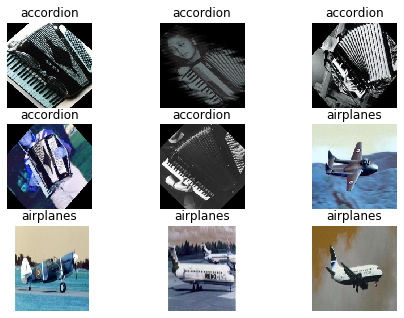

In [6]:
f,ax = plt.subplots(3,3) 
f.subplots_adjust(0,0,1,1)
index = 1
for i in range(0,3,1):
    for j in range(0,3,1):
        ax[i,j].imshow(Images[index*index*(i + j)])
        ax[i,j].set_title(Labels[index*index*(i + j)])
        ax[i,j].axis('off')
        index = index + 1

In [7]:
# Flatten images
X = Images.flatten().reshape(Images.shape[0], -1) / 255.0

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Labels, test_size=0.20, random_state=42)

In [9]:
class VAEModel(tf.keras.Model):
    def __init__(self,
                 encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 likelihood_dist_family: str,
                 **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

        if likelihood_dist_family not in ["Gaussian", "Bernoulli"]:
            raise NotImplementedError()
        else:
            self.likelihood_dist_family = likelihood_dist_family

        if self.likelihood_dist_family == "Gaussian":
            self.likelihood_std_raw = self.add_variable(
                name="likelihood_std", shape=[], dtype=tf.float32,
                initializer=tf.constant_initializer(0.0))
            self.likelihood_std = tf.nn.softplus(self.likelihood_std_raw) + 1e-4

    def call(self, inputs):
        # Model distributions
        apx_post_mean, apx_post_scale = self.encoder(inputs)
        apx_post = ed.Normal(
            loc=apx_post_mean,
            scale=apx_post_scale,
            name="apx_post"
        )

        prior = ed.Normal(
            loc=tf.zeros(tf.shape(apx_post)),
            scale=tf.ones(tf.shape(apx_post)),
            name="prior"
        )

        if self.likelihood_dist_family == "Gaussian":
            likelihood_rec = ed.Normal(
                loc=self.decoder(apx_post),
                scale=self.likelihood_std,
                name="likelihood_rec"
            )
            likelihood_gen = ed.Normal(
                loc=self.decoder(prior),
                scale=self.likelihood_std,
                name="likelihood_gen"
            )
        elif self.likelihood_dist_family == "Bernoulli":
            likelihood_rec = ed.Bernoulli(
                logits=self.decoder(apx_post),
                name="likelihood_rec"
            )
            likelihood_gen = ed.Bernoulli(
                logits=self.decoder(prior),
                name="likelihood_gen"
            )
        else:
            raise NotImplementedError()

        # Distortion
        sample_distortion = tf.reduce_sum(-likelihood_rec.distribution.log_prob(inputs), axis=-1)
        distortion = tf.reduce_mean(sample_distortion)

        # Rate
        sample_rate = (
                tf.reduce_sum(apx_post.distribution.log_prob(apx_post), axis=-1) -
                tf.reduce_sum(prior.distribution.log_prob(apx_post), axis=-1)
        )
        rate = tf.reduce_mean(sample_rate)

        # Loss
        loss = distortion + rate

        # Add loss and metrics
        self.add_loss(loss)
        self.add_metric(rate, name="rate", aggregation="mean")
        self.add_metric(distortion, name="distortion", aggregation="mean")

        return [
            apx_post.value,
            likelihood_rec.distribution.mean(),
            likelihood_gen.distribution.mean(),
        ]

In [12]:
SEED = 2
LIKELIHOOD_DIST_FAMILY = "Gaussian"

OBS_DIM = X_train.shape[1]
LATENT_DIM = 101

LEARNING_RATE = 1e-4
EPOCHS = 50
BATCH_SIZE = 32

In [13]:
np.random.seed(SEED)
tf.set_random_seed(SEED)

# example inputs
inputs = tfkl.Input((OBS_DIM,), dtype=tf.float32, name='inputs')
latent_inputs = tfkl.Input((LATENT_DIM,), dtype=tf.float32, name='latent_inputs')

# example encoder (Note: the encoder must output the mean and std for a Gaussian)
encoder_x = inputs
for i in range(2):
    encoder_x = tfkl.Dense(256, activation="relu",
                           name="hidden/dense_encoder_{}".format(i))(encoder_x)
encoder_output_mean = tfkl.Dense(LATENT_DIM, name="encoder_output_mean")(encoder_x)
encoder_output_std = tfkl.Dense(LATENT_DIM, activation=lambda x: tf.nn.softplus(x) + 1e-4,
                                name="encoder_output_std")(encoder_x)
encoder = tf.keras.Model(inputs, [encoder_output_mean, encoder_output_std], name="encoder")

# example decoder (Note: the decoder must output either the mean for a Gaussian or the logits for a Bernoulli)
decoder_x = latent_inputs
for i in range(2):
    decoder_x = tfkl.Dense(256, activation="relu",
                           name="hidden/dense_decoder_{}".format(i))(decoder_x)
decoder_output = tfkl.Dense(OBS_DIM, name="decoder_output_mean")(decoder_x)
decoder = tf.keras.Model(latent_inputs, decoder_output, name="decoder")

# keras model
vae_model = VAEModel(
    encoder=encoder,
    decoder=decoder,
    likelihood_dist_family=LIKELIHOOD_DIST_FAMILY,
)
vae_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))

In [14]:
a = datetime.datetime.now()
# train
vae_model.fit(X_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

b = datetime.datetime.now()
print("Total Time")
print(b - a)


D:\Anaconda\envs\tensorflow\lib\site-packages\tensorflow_core\python\autograph\converters\directives.py:119: UserWarning: tfp.edward2 module is deprecated and will be removed on 2019-12-01. Use https://github.com/google/edward2 library instead.
  if hasattr(parent_val, node.attr):


Train on 7316 samples
Epoch 1/50
7316/7316 [==============================] - 56s 8ms/sample - loss: 42011.7997 - rate: 257.6411 - distortion: 41750.6992
Epoch 2/50
7316/7316 [==============================] - 36s 5ms/sample - loss: 39204.9852 - rate: 170.1425 - distortion: 39033.1797
Epoch 3/50
7316/7316 [==============================] - 38s 5ms/sample - loss: 37675.5432 - rate: 182.5078 - distortion: 37491.6445
Epoch 4/50
7316/7316 [==============================] - 36s 5ms/sample - loss: 36448.3966 - rate: 177.1128 - distortion: 36270.4844
Epoch 5/50
7316/7316 [==============================] - 36s 5ms/sample - loss: 35217.3306 - rate: 185.2558 - distortion: 35030.7031
Epoch 6/50
7316/7316 [==============================] - 38s 5ms/sample - loss: 33995.9502 - rate: 190.7475 - distortion: 33804.5117
Epoch 7/50
7316/7316 [==============================] - 36s 5ms/sample - loss: 32834.0604 - rate: 192.8662 - distortion: 32639.1094
Epoch 8/50
7316/7316 [==============================] 

In [15]:
# evaluate
vae_model.evaluate(X_test)

# predict
encs, recs, gens = vae_model.predict(X_test)

1829/1829 [==============================] - 7s 4ms/sample - loss: -13102.3322 - rate: 307.1211 - distortion: -13424.1963


In [16]:
y_test.shape

(1829,)

In [17]:
c = 1
mapping = {}
for i in range(y_test.shape[0]):
    if y_test[i] in mapping.keys():
        y_test[i] = mapping[y_test[i]]
    else:
        mapping[y_test[i]] = c
        y_test[i] = c
        c = c + 1

In [18]:
y_test = y_test.astype(int)

In [19]:
y_test = y_test / 204

In [20]:
if LATENT_DIM == 2:
    plt.figure(figsize=(6, 6))
    plt.title('Latent dim', size=16)
    plt.scatter(*encs.T, c=y_test)

In [21]:
OBS_SHAPE = (150, 150, 3)

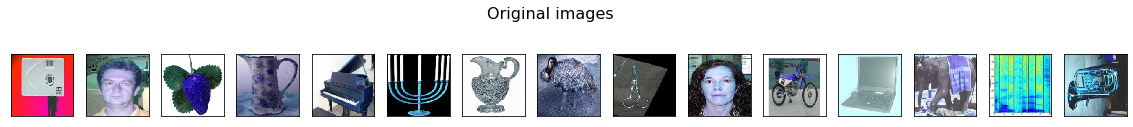

In [22]:
plt.figure(figsize=(20, 4))
plt.suptitle('Original images', size=16)
for i in range(15):
    ax = plt.subplot(2, 15, i + 1)
    plt.imshow(X_test[i*10].reshape(OBS_SHAPE))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

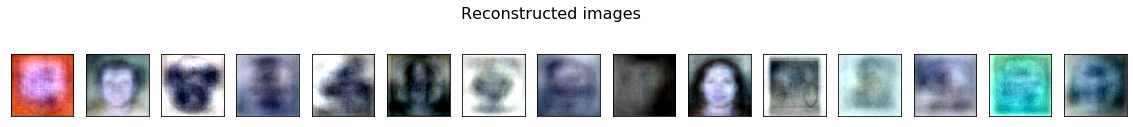

In [23]:
plt.figure(figsize=(20, 4))
plt.suptitle('Reconstructed images', size=16)
for i in range(15):
    ax = plt.subplot(2, 15, i + 1)
    plt.imshow(recs[i * 10].reshape(OBS_SHAPE))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

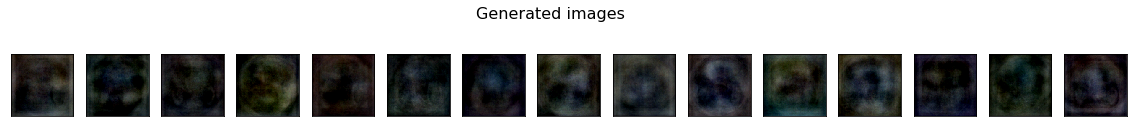

In [24]:
plt.figure(figsize=(20, 4))
plt.suptitle('Generated images', size=16)
for i in range(15):
    ax = plt.subplot(2, 15, i + 1)
    plt.imshow(gens[i * 10].reshape(OBS_SHAPE))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [25]:
train_encs, train_recs, train_gens = vae_model.predict(X_train)

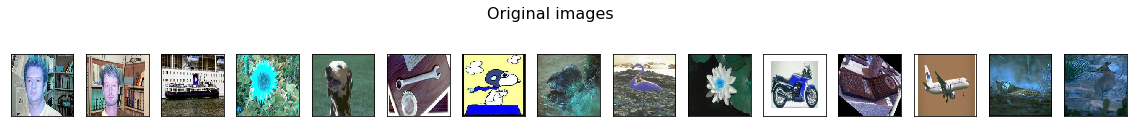

In [26]:
plt.figure(figsize=(20, 4))
plt.suptitle('Original images', size=16)
for i in range(15):
    ax = plt.subplot(2, 15, i + 1)
    plt.imshow(X_train[i*10].reshape(OBS_SHAPE))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

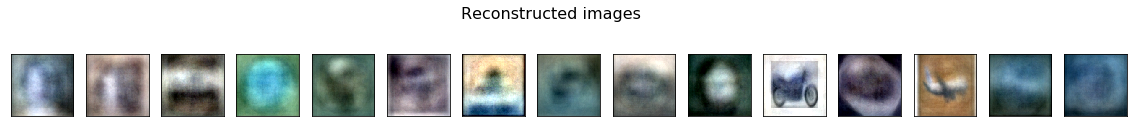

In [27]:
plt.figure(figsize=(20, 4))
plt.suptitle('Reconstructed images', size=16)
for i in range(15):
    ax = plt.subplot(2, 15, i + 1)
    plt.imshow(train_recs[i * 10].reshape(OBS_SHAPE))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

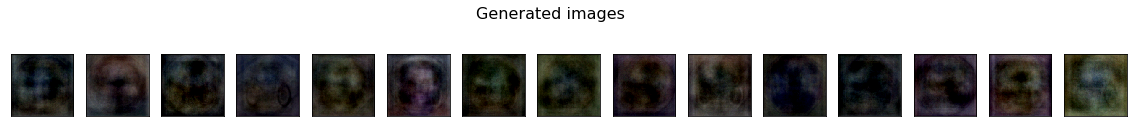

In [28]:
plt.figure(figsize=(20, 4))
plt.suptitle('Generated images', size=16)
for i in range(15):
    ax = plt.subplot(2, 15, i + 1)
    plt.imshow(train_gens[i * 10].reshape(OBS_SHAPE))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)